# MNIST CNN

上一個練習中我們的 input data 是攤平成一維向量，然後自己調用底層 function 做數值運算

這邊帶入 CNN 概念，講 input data 視為二維圖片處理，並調用 high-level functino 做一連串處理

- tf.layers
- name_scope
- batch normalization (BN)

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('data/mnist', one_hot=True)

import os
import argparse
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from datetime import datetime
print(f"tensorflow version {tf.__version__}")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
tensorflow version 1.11.0


In [2]:
def argparser():
    parser = argparse.ArgumentParser()
    
    # training parameter
    parser.add_argument('--gpu', dest='gpu', required=True, \
                        help='require one GPU to execute')
    parser.add_argument('--lr', dest='lr', \
                        default=0.1, type=float, \
                        help='learning rate')
    parser.add_argument('--steps', dest='steps', \
                        default=500, type=int, \
                        help='number of update steps')
    parser.add_argument('--bz', dest='bz', \
                        default=128, type=int, \
                        help='batch size')
    parser.add_argument('--display-steps', dest='display_steps', \
                        default=100, type=int, \
                        help='display steps')
    
    # network parameter
    parser.add_argument('--input-shape', dest='input_shape', \
                        default=784, nargs='+', type=int)
    parser.add_argument('--num-class', dest='n_output', \
                        default=10, type=int)
    parser.add_argument('--ckpt-savepath', dest='ckpt_savepath', \
                        default='outputs/01_mnist_CNN/mnist_layers.ckpt')
    return parser

# setting args
args = argparser().parse_args([
    '--gpu', '3',
    '--lr', '0.0001',
    '--input-shape', '784'
])
print(args)
os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu

Namespace(bz=128, ckpt_savepath='outputs/01_mnist_CNN/mnist_layers.ckpt', display_steps=100, gpu='3', input_shape=[784], lr=0.0001, n_output=10, steps=500)


In [3]:
def build_model(features, n_class):
    # input layer
    input_layer = tf.reshape(features, [-1, 28, 28, 1], name='input')
    
    # conv1
    conv1 = tf.layers.conv2d(input_layer, filters=32, kernel_size=5, padding='same', name='conv_1')
    conv1 = tf.layers.batch_normalization(conv1, name='bn_1')
    conv1 = tf.nn.relu(conv1, name='relu_1')
    pool1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2)
    
    # conv2
    conv2 = tf.layers.conv2d(pool1, filters=64, kernel_size=5, padding='same', name='conv_2')
    conv2 = tf.layers.batch_normalization(conv2, name='bn_2')
    conv2 = tf.nn.relu(conv2, name='relu_2')
    
    # dense layer
    flat = tf.layers.flatten(conv2, name='flatten')
    dense = tf.layers.dense(flat, 1024, activation=tf.nn.relu, name='dense')
    dropout = tf.layers.dropout(inputs=dense, rate=0.5)
    
    # output layer (logits)
    output_layer = tf.layers.dense(dropout, n_class, name='output')
    return output_layer

tf.reset_default_graph()

# define placeholder
x_train = tf.placeholder('float', [None, *args.input_shape])
y_train = tf.placeholder('float', [None, args.n_output])

# define model graph
logits = build_model(x_train, args.n_output)
y_pred = tf.nn.softmax(logits=logits)

# compile model - define loss and optimizer
op_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_train))
optimizer = tf.train.AdamOptimizer(learning_rate=args.lr)
op_update = optimizer.minimize(op_loss)

# evaluate model
correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_train, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [4]:
# # check model graph
# import tensorflow.contrib.slim as slim
# model_vars = tf.trainable_variables()
# slim.model_analyzer.analyze_vars(model_vars, print_info=True)

# training
init = tf.global_variables_initializer()
saver = tf.train.Saver()
start_time = datetime.now()

with tf.Session() as sess:
    sess.run(init)
    
    # iterate update
    for step in range(1, args.steps):
        batch_x, batch_y = mnist_data.train.next_batch(args.bz)
        
        # optimize (back propagation) and print message
        sess.run(op_update, feed_dict={x_train: batch_x, y_train: batch_y})
        if step == 1 or step % args.display_steps == 0:
            loss, acc = sess.run([op_loss, accuracy], feed_dict={x_train: batch_x, y_train: batch_y})
            print(f"step {step:4d} - loss={loss:.4f}, acc={acc:.3f}")
    print('optimization finished')
        
    # save model
    ckpt_savepath = Path(args.ckpt_savepath)
    if not ckpt_savepath.parent.exists():
        ckpt_savepath.parent.mkdir(parents=True)
    ckpt_savepath = saver.save(sess, args.ckpt_savepath)
    print(f"Save model - {args.ckpt_savepath}")
    print(f"Trining time - {str(datetime.now() - start_time)}")

step    1 - loss=2.1879, acc=0.477
step  100 - loss=0.2835, acc=0.906
step  200 - loss=0.3227, acc=0.914
step  300 - loss=0.1495, acc=0.938
step  400 - loss=0.0932, acc=0.984
optimization finished
Save model - outputs/01_mnist_CNN/mnist_layers.ckpt
Trining time - 0:00:08.023127


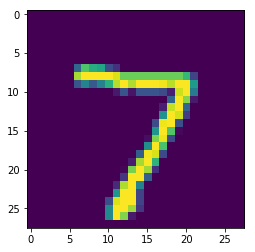

INFO:tensorflow:Restoring parameters from outputs/01_mnist_CNN/mnist_layers.ckpt
Model restored from outputs/01_mnist_CNN/mnist_layers.ckpt
Testing accuracy: 0.9735999703407288
Predict image label = [7]


In [5]:
# inference and test
plt.imshow(mnist_data.test.images[0].reshape((28, 28)))
plt.show()

with tf.Session() as sess:
    sess.run(init)
    
    # restore model
    saver.restore(sess, args.ckpt_savepath)
    print(f"Model restored from {args.ckpt_savepath}")
    
    # calc accuracy for MNIST test images
    print(f"Testing accuracy: {sess.run(accuracy, feed_dict={\
            x_train: mnist_data.test.images, y_train: mnist_data.test.labels})}")
    
    # predict first test image
    print(f"Predict image label = {sess.run(tf.argmax(y_pred, 1), feed_dict={\
            x_train: mnist_data.test.images[0:1]})}")